Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

2023-03-02 21:47:05.887723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 21:47:06.037056: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-02 21:47:06.478660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-03-02 21:47:06.478721: W tensorflow/stream_executor/platfo

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [4]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [5]:
MAX_FRAMES = 5
X_npy_fname = f'X_3d-avg-{MAX_FRAMES}_frames.npy'
y_npy_fname = f'y.npy'


if CFG.is_training:
    try:
        X = np.load(X_npy_fname)
        y = np.load(y_npy_fname)
    except:
        print('True')
        X = np.zeros((len(train), 543, 3))
        y = np.zeros((len(train),))
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            data_resize = tf.image.resize(
                data,
                (MAX_FRAMES, 543),
                method='nearest',
            )
            X[i] = np.mean(data_resize, axis=0)
            y[i] = train.iloc[i].label
            num_frames[i] = data.shape[0]
            if CFG.quick_experiment and i == 4999:
                break
        ## Save number of frames of each training sample for data analysis
        train["num_frames"] = num_frames
        print(train["num_frames"].describe())
        train.to_csv("train.csv", index=False)
        np.save(X_npy_fname, X)
        np.save(y_npy_fname, y)

    print(X.shape, y.shape)

(94477, 543, 3) (94477,)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)


|part|start|end|
|----|--|---|
|face| 0| 467|
|left_hand| 468| 488|
|pose| 489| 521|
|right_hand| 522| 542|

In [7]:
N_FACE_PTS = 468
N_HAND_PTS = 21
N_POSE_PTS = 33
N_DIMS = 3
N_PTS = 543
assert N_PTS == (N_FACE_PTS + 2*N_HAND_PTS + N_POSE_PTS)

N_NEURONS_CONCAT = 32
N_NEURONS_POSE = 32


all_input = tf.keras.layers.Input(shape=(N_PTS,N_DIMS))
# intermediate = tf.keras.layers.Reshape((500,1), input_shape=(500,))(intermediate)


input_face = tf.keras.layers.Lambda(
    lambda x: x[:, 0:468, :],
    output_shape=(N_FACE_PTS, N_DIMS),
)(all_input)
input_left = tf.keras.layers.Lambda(
    lambda x: x[:, 468:489, :],
    output_shape=(N_HAND_PTS, N_DIMS),
)(all_input)
input_pose = tf.keras.layers.Lambda(
    lambda x: x[:, 489:522, :],
    output_shape=(N_HAND_PTS, N_DIMS),
)(all_input)

input_right = tf.keras.layers.Lambda(
    lambda x: x[:, 522:, :],
    output_shape=(N_POSE_PTS, N_DIMS),
)(all_input)



head_avg = tf.keras.layers.Lambda(
    lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(input_face)
head_var = tf.keras.layers.Lambda(
    lambda x: tf.math.reduce_variance(x, axis=1, keepdims=True))(input_face)

# Head + left + right --> Compress
hands_combo = tf.keras.layers.Concatenate(axis=1)([
    head_avg,
    head_var,
    input_left,
    input_right,
])
hands_combo = tf.keras.layers.Dense(128, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(64, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(64, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(32, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(
    N_NEURONS_POSE,
    activation='relu',
)(hands_combo)


# Pose
pose = tf.keras.layers.Dense(N_NEURONS_POSE, activation='relu')(input_pose)
# Pose and Hands
pose_hands = tf.keras.layers.Concatenate(axis=1)(
    [hands_combo, pose]
)
pose_hands = tf.keras.layers.Dense(32, activation='relu')(pose_hands)

left = tf.keras.layers.Dense(32, activation='relu')(input_left)
right = tf.keras.layers.Dense(32, activation='relu')(input_right)

# Deep Wide
combo = tf.keras.layers.Concatenate(axis=1)([
    pose_hands,
    left,
    right,
])
combo = tf.keras.layers.Dense(64, activation='relu')(combo)
combo = tf.keras.layers.Dense(128, activation='relu')(combo)

x = tf.keras.layers.GRU(256, return_sequences=True)(combo)
x = tf.keras.layers.GRU(256,)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(250, activation='softmax')(x)

model = tf.keras.models.Model(
    inputs=[
        all_input,
    ],
    outputs=out,
)


model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

model.summary()

2023-03-02 21:47:07.880760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 21:47:07.885277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 21:47:07.885443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 21:47:07.886002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 543, 3)]     0           []                               
                                                                                                  
 lambda (Lambda)                (None, 468, 3)       0           ['input_1[0][0]']                
                                                                                                  
 lambda_4 (Lambda)              (None, 1, 3)         0           ['lambda[0][0]']                 
                                                                                                  
 lambda_5 (Lambda)              (None, 1, 3)         0           ['lambda[0][0]']                 
                                                                                              

In [8]:
if True:
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('model-head_avg-.h5'),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
        ),
    ]
    history = model.fit(
        X_train,
        y_train,
        epochs=500,
        validation_data=(X_val, y_val),
        batch_size=128,
        callbacks=callbacks,
    )
else:
    model = tf.keras.models.load_model("../model.h5")

Epoch 1/500


2023-03-02 21:47:13.029618: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-02 21:47:13.514623: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


591/591 [==============================] - 22s 31ms/step - loss: 5.4508 - accuracy: 0.0051 - top-05-acc: 0.0286 - top-10-acc: 0.0565 - val_loss: 5.3372 - val_accuracy: 0.0079 - val_top-05-acc: 0.0405 - val_top-10-acc: 0.0810
Epoch 2/500
591/591 [==============================] - 17s 29ms/step - loss: 5.1494 - accuracy: 0.0140 - top-05-acc: 0.0648 - top-10-acc: 0.1228 - val_loss: 5.0123 - val_accuracy: 0.0212 - val_top-05-acc: 0.0876 - val_top-10-acc: 0.1620
Epoch 3/500
591/591 [==============================] - 17s 29ms/step - loss: 4.7948 - accuracy: 0.0349 - top-05-acc: 0.1371 - top-10-acc: 0.2332 - val_loss: 4.5665 - val_accuracy: 0.0542 - val_top-05-acc: 0.1969 - val_top-10-acc: 0.3018
Epoch 4/500
591/591 [==============================] - 17s 29ms/step - loss: 4.5053 - accuracy: 0.0537 - top-05-acc: 0.2026 - top-10-acc: 0.3267 - val_loss: 4.4350 - val_accuracy: 0.0621 - val_top-05-acc: 0.2241 - val_top-10-acc: 0.3533
Epoch 5/500
591/591 [==============================] - 18s 30ms/

591/591 [==============================] - 18s 30ms/step - loss: 2.6219 - accuracy: 0.3720 - top-05-acc: 0.6665 - top-10-acc: 0.7602 - val_loss: 2.6878 - val_accuracy: 0.3730 - val_top-05-acc: 0.6549 - val_top-10-acc: 0.7490
Epoch 36/500
591/591 [==============================] - 17s 28ms/step - loss: 2.5998 - accuracy: 0.3777 - top-05-acc: 0.6721 - top-10-acc: 0.7640 - val_loss: 2.6436 - val_accuracy: 0.3812 - val_top-05-acc: 0.6668 - val_top-10-acc: 0.7569
Epoch 37/500
591/591 [==============================] - 17s 29ms/step - loss: 2.5893 - accuracy: 0.3812 - top-05-acc: 0.6735 - top-10-acc: 0.7652 - val_loss: 2.6507 - val_accuracy: 0.3764 - val_top-05-acc: 0.6640 - val_top-10-acc: 0.7575
Epoch 38/500
591/591 [==============================] - 17s 29ms/step - loss: 2.5722 - accuracy: 0.3845 - top-05-acc: 0.6757 - top-10-acc: 0.7669 - val_loss: 2.5988 - val_accuracy: 0.3911 - val_top-05-acc: 0.6742 - val_top-10-acc: 0.7611
Epoch 39/500
591/591 [==============================] - 17s 2

591/591 [==============================] - 17s 29ms/step - loss: 2.3278 - accuracy: 0.4448 - top-05-acc: 0.7177 - top-10-acc: 0.7933 - val_loss: 2.5568 - val_accuracy: 0.4164 - val_top-05-acc: 0.6788 - val_top-10-acc: 0.7630
Epoch 70/500
591/591 [==============================] - 17s 29ms/step - loss: 2.3163 - accuracy: 0.4481 - top-05-acc: 0.7190 - top-10-acc: 0.7948 - val_loss: 2.5593 - val_accuracy: 0.4211 - val_top-05-acc: 0.6887 - val_top-10-acc: 0.7687
Epoch 71/500
591/591 [==============================] - 17s 29ms/step - loss: 2.3141 - accuracy: 0.4476 - top-05-acc: 0.7212 - top-10-acc: 0.7959 - val_loss: 2.5652 - val_accuracy: 0.4193 - val_top-05-acc: 0.6819 - val_top-10-acc: 0.7635
Epoch 72/500
591/591 [==============================] - 17s 29ms/step - loss: 2.3136 - accuracy: 0.4477 - top-05-acc: 0.7203 - top-10-acc: 0.7952 - val_loss: 2.5783 - val_accuracy: 0.4126 - val_top-05-acc: 0.6770 - val_top-10-acc: 0.7616
Epoch 73/500
591/591 [==============================] - 17s 2

In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top-05-acc', 'top-10-acc', 'val_loss', 'val_accuracy', 'val_top-05-acc', 'val_top-10-acc'])


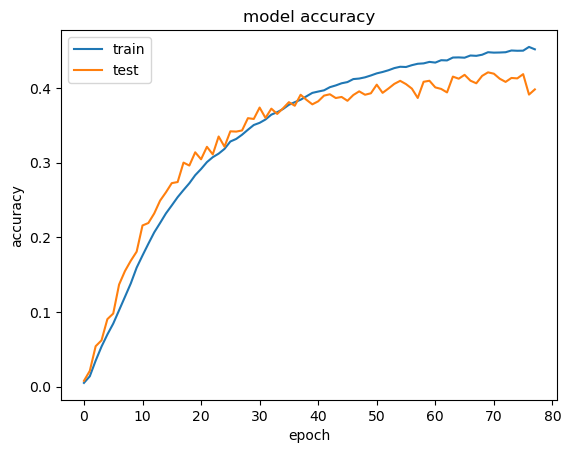

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

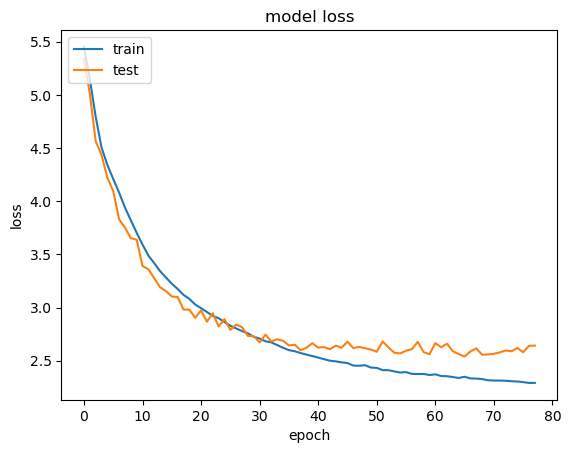

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
N_FACE_PTS = 468
N_HAND_PTS = 21
N_POSE_PTS = 33
N_DIMS = 3
N_PTS = 543
assert N_PTS == (N_FACE_PTS + 2*N_HAND_PTS + N_POSE_PTS)

N_NEURONS_CONCAT = 32
N_NEURONS_POSE = 32


all_input = tf.keras.layers.Input(shape=(N_PTS,N_DIMS))
# intermediate = tf.keras.layers.Reshape((500,1), input_shape=(500,))(intermediate)


input_face = tf.keras.layers.Lambda(
    lambda x: x[:, 0:468, :],
    output_shape=(N_FACE_PTS, N_DIMS),
)(all_input)
input_left = tf.keras.layers.Lambda(
    lambda x: x[:, 468:489, :],
    output_shape=(N_HAND_PTS, N_DIMS),
)(all_input)
input_pose = tf.keras.layers.Lambda(
    lambda x: x[:, 489:522, :],
    output_shape=(N_HAND_PTS, N_DIMS),
)(all_input)
input_right = tf.keras.layers.Lambda(
    lambda x: x[:, 522:, :],
    output_shape=(N_POSE_PTS, N_DIMS),
)(all_input)


head_avg = tf.keras.layers.Lambda(
    lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(input_face)
head_var = tf.keras.layers.Lambda(
    lambda x: tf.math.reduce_variance(x, axis=1, keepdims=True))(input_face)

# Head + left + right --> Compress
hands_combo = tf.keras.layers.Concatenate(axis=1)([
    head_avg,
    head_var,
    input_left,
    input_right,
])
hands_combo = tf.keras.layers.Dense(128, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(64, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(64, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dropout(0.2)(hands_combo)
hands_combo = tf.keras.layers.Dense(32, activation='relu')(hands_combo)
hands_combo = tf.keras.layers.Dense(N_NEURONS_POSE, activation='relu',)(hands_combo)


# Pose
pose = tf.keras.layers.Dense(N_NEURONS_POSE, activation='relu')(input_pose)
# Pose and Hands
pose_hands = tf.keras.layers.Concatenate(axis=1)(
    [hands_combo, pose]
)
pose_hands = tf.keras.layers.Dense(64, activation='relu')(pose_hands)
pose_hands = tf.keras.layers.Dense(64, activation='relu')(pose_hands)
# pose_hands = tf.keras.layers.Dropout(0.2)(pose_hands)
pose_hands = tf.keras.layers.Dense(N_NEURONS_CONCAT, activation='relu')(pose_hands)

# Deep Wide
left = tf.keras.layers.Dense(N_NEURONS_CONCAT, activation='relu')(input_left)
right = tf.keras.layers.Dense(N_NEURONS_CONCAT, activation='relu')(input_right)
combo = tf.keras.layers.Concatenate(axis=1)([
    pose_hands,
    left,
    right,
])
combo = tf.keras.layers.Dense(64, activation='relu')(combo)
combo = tf.keras.layers.Dense(128, activation='relu')(combo)

x = tf.keras.layers.GRU(256, return_sequences=True)(combo)
x = tf.keras.layers.GRU(256,)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(250, activation='softmax')(x)

model = tf.keras.models.Model(
    inputs=[
        all_input,
    ],
    outputs=out,
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 543, 3)]     0           []                               
                                                                                                  
 lambda_6 (Lambda)              (None, 468, 3)       0           ['input_2[0][0]']                
                                                                                                  
 lambda_10 (Lambda)             (None, 1, 3)         0           ['lambda_6[0][0]']               
                                                                                                  
 lambda_11 (Lambda)             (None, 1, 3)         0           ['lambda_6[0][0]']               
                                                                                            

__________________________________________________________________________________________________


In [13]:
if True:
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('model-head_avg.h5'),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
        ),
    ]
    history = model.fit(
        X_train,
        y_train,
        epochs=500,
        validation_data=(X_val, y_val),
        batch_size=128,
        callbacks=callbacks,
    )
else:
    model = tf.keras.models.load_model("../model.h5")

Epoch 1/500
591/591 [==============================] - 21s 31ms/step - loss: 5.4448 - accuracy: 0.0056 - top-05-acc: 0.0285 - top-10-acc: 0.0562 - val_loss: 5.5947 - val_accuracy: 0.0076 - val_top-05-acc: 0.0365 - val_top-10-acc: 0.0715
Epoch 2/500
591/591 [==============================] - 18s 31ms/step - loss: 5.1877 - accuracy: 0.0126 - top-05-acc: 0.0588 - top-10-acc: 0.1107 - val_loss: 5.0290 - val_accuracy: 0.0202 - val_top-05-acc: 0.0874 - val_top-10-acc: 0.1530
Epoch 3/500
591/591 [==============================] - 17s 29ms/step - loss: 4.9579 - accuracy: 0.0242 - top-05-acc: 0.1055 - top-10-acc: 0.1877 - val_loss: 4.7247 - val_accuracy: 0.0400 - val_top-05-acc: 0.1585 - val_top-10-acc: 0.2596
Epoch 4/500
591/591 [==============================] - 17s 29ms/step - loss: 4.5803 - accuracy: 0.0498 - top-05-acc: 0.1888 - top-10-acc: 0.3098 - val_loss: 4.4923 - val_accuracy: 0.0626 - val_top-05-acc: 0.2222 - val_top-10-acc: 0.3504
Epoch 5/500
591/591 [==============================]

591/591 [==============================] - 18s 30ms/step - loss: 2.6224 - accuracy: 0.3729 - top-05-acc: 0.6689 - top-10-acc: 0.7606 - val_loss: 2.6610 - val_accuracy: 0.3748 - val_top-05-acc: 0.6609 - val_top-10-acc: 0.7506
Epoch 36/500
591/591 [==============================] - 17s 29ms/step - loss: 2.6034 - accuracy: 0.3768 - top-05-acc: 0.6720 - top-10-acc: 0.7629 - val_loss: 2.6471 - val_accuracy: 0.3765 - val_top-05-acc: 0.6611 - val_top-10-acc: 0.7510
Epoch 37/500
591/591 [==============================] - 18s 31ms/step - loss: 2.5886 - accuracy: 0.3808 - top-05-acc: 0.6748 - top-10-acc: 0.7658 - val_loss: 2.6803 - val_accuracy: 0.3719 - val_top-05-acc: 0.6600 - val_top-10-acc: 0.7550
Epoch 38/500
591/591 [==============================] - 17s 29ms/step - loss: 2.5742 - accuracy: 0.3844 - top-05-acc: 0.6769 - top-10-acc: 0.7660 - val_loss: 2.6762 - val_accuracy: 0.3814 - val_top-05-acc: 0.6592 - val_top-10-acc: 0.7491
Epoch 39/500
591/591 [==============================] - 18s 3

591/591 [==============================] - 18s 31ms/step - loss: 2.3415 - accuracy: 0.4415 - top-05-acc: 0.7149 - top-10-acc: 0.7906 - val_loss: 2.6574 - val_accuracy: 0.4036 - val_top-05-acc: 0.6674 - val_top-10-acc: 0.7541
Epoch 70/500
591/591 [==============================] - 17s 29ms/step - loss: 2.3288 - accuracy: 0.4433 - top-05-acc: 0.7164 - top-10-acc: 0.7921 - val_loss: 2.5598 - val_accuracy: 0.4119 - val_top-05-acc: 0.6801 - val_top-10-acc: 0.7633
Epoch 71/500
591/591 [==============================] - 18s 30ms/step - loss: 2.3268 - accuracy: 0.4434 - top-05-acc: 0.7174 - top-10-acc: 0.7921 - val_loss: 2.5357 - val_accuracy: 0.4187 - val_top-05-acc: 0.6865 - val_top-10-acc: 0.7659
Epoch 72/500
591/591 [==============================] - 19s 32ms/step - loss: 2.3347 - accuracy: 0.4418 - top-05-acc: 0.7155 - top-10-acc: 0.7919 - val_loss: 2.5882 - val_accuracy: 0.4096 - val_top-05-acc: 0.6813 - val_top-10-acc: 0.7615
Epoch 73/500
591/591 [==============================] - 19s 3

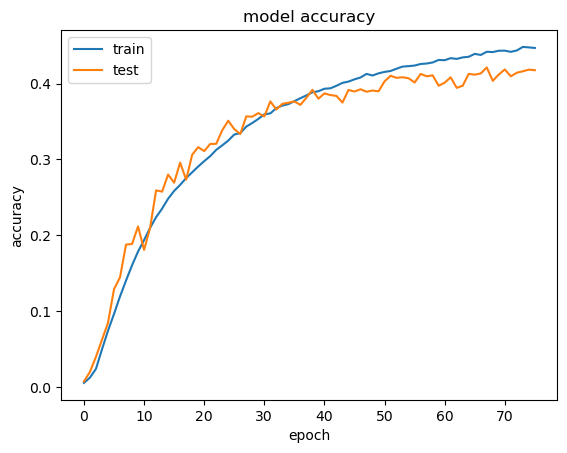

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

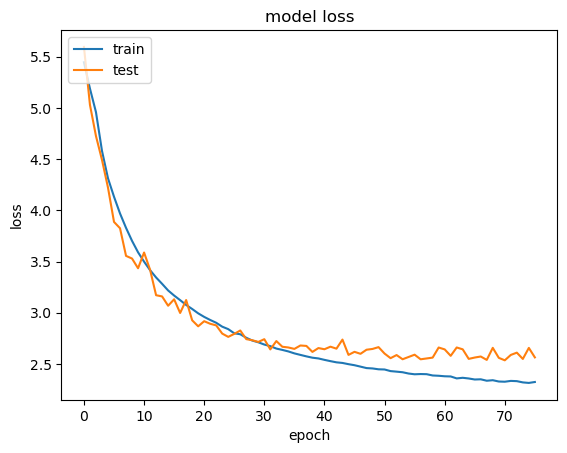

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()